#             Project 1


# The history of eigenvalue computations

# Task 1 Generate graphs from the data

a) A straight-forward way of defining a graph on publication data is a \coauthorship graph" GC =
(VC; EC). In this graph, each node v 2 VC corresponds to an author, and there is an edge between
authors u and v if they are coauthors (i.e., if there is a publication which both of them have
authored).
Write a function that reads in the file eigenvalue publications.txt and generates the corresponding coauthorship graph. If you want, you can also define a weighted coauthorship graph with
a suitable weight function.

In [89]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt 
from itertools import combinations
from functools import partial
from scipy.sparse.linalg import eigs
from scipy.linalg import expm
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
from itertools import islice
from collections import Counter
import math
import warnings
warnings.filterwarnings('ignore')



In [90]:
data = pd.read_csv('references.csv')
data.shape

(6174, 4)

In [91]:
data['Title'].nunique()

6117

In [92]:
data.insert(loc=1,
          column='Author_ID',
          value=np.random.randint(1, 7000, size=6174))


In [93]:
data

Item type  Author_ID                    Authors  \
0     Journal Article        712              Van Diejen JF   
1     Journal Article       5948             Truhar N,Li RC   
2     Journal Article       6746  Li JF,Li W,Duan XF,Xiao M   
3     Journal Article       3337         Bauer JO,Drabant B   
4     Journal Article       4214                 Kamenski L   
...               ...        ...                        ...   
6169  Journal Article       4791                Bargmann RE   
6170  Journal Article       5677             De Oliveira GN   
6171  Journal Article       5035             Prikazcikov VG   
6172  Journal Article       1716               Baklanova VA   
6173  Journal Article       3137                  Laborde F   

                                                  Title Date published  
0     $q$-Deformation of the Kac-Sylvester tridiagon...           2021  
1     On an eigenvector-dependent nonlinear eigenval...           2021  
2     Newton's method for the parameterized generali...           2021  
3                            Principal loading analysis           2021  
4     Sharp Bounds on the Smallest Eigenvalue of Fin...           2021  
...                                                 ...            ...  
6169  Principles and design of statistical computer ...           1969  
6170  Some remarks on the localization of the charac...           1969  
6171  The symmetrization of difference eigenvalue pr...           1969  
6172  More precise determination of an eigenvalue an...           1968  
6173  Recherche des valeurs propres d'operateurs de ...           1966  

[6174 rows x 5 columns]

In [94]:
data.rename(columns = {'Date published':'Date_published'}, inplace = True)
data.head()

Item type  Author_ID                    Authors  \
0  Journal Article        712              Van Diejen JF   
1  Journal Article       5948             Truhar N,Li RC   
2  Journal Article       6746  Li JF,Li W,Duan XF,Xiao M   
3  Journal Article       3337         Bauer JO,Drabant B   
4  Journal Article       4214                 Kamenski L   

                                               Title Date_published  
0  $q$-Deformation of the Kac-Sylvester tridiagon...           2021  
1  On an eigenvector-dependent nonlinear eigenval...           2021  
2  Newton's method for the parameterized generali...           2021  
3                         Principal loading analysis           2021  
4  Sharp Bounds on the Smallest Eigenvalue of Fin...           2021

In [95]:
data=data.applymap(str)  

In [96]:
data['author_list'] = data['Authors'].str.split(',')
data['author_id_list'] = data['Author_ID'].str.split(';')

In [97]:
#create mapping between authors and IDs if needed
def cmp(x, y):
    mapping = dict(zip(x, y))
    return mapping


data['author_id_mapping'] = data.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)

In [98]:
# create df with just titles and author fields
pairs = data[['Title', 'Authors']]
pairs

Title  \
0     $q$-Deformation of the Kac-Sylvester tridiagon...   
1     On an eigenvector-dependent nonlinear eigenval...   
2     Newton's method for the parameterized generali...   
3                            Principal loading analysis   
4     Sharp Bounds on the Smallest Eigenvalue of Fin...   
...                                                 ...   
6169  Principles and design of statistical computer ...   
6170  Some remarks on the localization of the charac...   
6171  The symmetrization of difference eigenvalue pr...   
6172  More precise determination of an eigenvalue an...   
6173  Recherche des valeurs propres d'operateurs de ...   

                        Authors  
0                 Van Diejen JF  
1                Truhar N,Li RC  
2     Li JF,Li W,Duan XF,Xiao M  
3            Bauer JO,Drabant B  
4                    Kamenski L  
...                         ...  
6169                Bargmann RE  
6170             De Oliveira GN  
6171             Prikazcikov VG  
6172               Baklanova VA  
6173                  Laborde F  

[6174 rows x 2 columns]

In [99]:
# create author author pairs for each paper
paired = (data.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

In [100]:
paired

Title            Authors
0      $q$-Deformation of the Kac-Sylvester tridiagon...                NaN
1      On an eigenvector-dependent nonlinear eigenval...  (Truhar N, Li RC)
2      Newton's method for the parameterized generali...      (Li JF, Li W)
3      Newton's method for the parameterized generali...   (Li JF, Duan XF)
4      Newton's method for the parameterized generali...    (Li JF, Xiao M)
...                                                  ...                ...
12215  Principles and design of statistical computer ...                NaN
12216  Some remarks on the localization of the charac...                NaN
12217  The symmetrization of difference eigenvalue pr...                NaN
12218  More precise determination of an eigenvalue an...                NaN
12219  Recherche des valeurs propres d'operateurs de ...                NaN

[12220 rows x 2 columns]

In [101]:
paired.groupby('Authors').size().sort_values(ascending=False)

Authors
(Mehrmann V, Xu H)           16
(Imakura A, Sakurai T)       16
(Cullum JK, Willoughby R)    14
(De Teran F, Dopico F)       14
(Huang TM, Lin WW)           14
                             ..
(Meyer A, Doehler B)          1
(Meyer A, Flemming U)         1
(Meyer A, Lang W)             1
(Meyer CD, Stewart GW)        1
(Abaffy J, Bertocchi M)       1
Length: 7570, dtype: int64

In [102]:
df = paired.groupby('Authors').size().to_frame(name = 'count').reset_index()

In [103]:
# split the pairs of authors into two columns
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df[col] = df['Authors'].apply(lambda location: location[n])

In [104]:
df.sort_values('count',ascending=False)

Authors  count    author_0      author_1
3269     (Imakura A, Sakurai T)     16   Imakura A     Sakurai T
4841         (Mehrmann V, Xu H)     16  Mehrmann V          Xu H
1618     (De Teran F, Dopico F)     14  De Teran F      Dopico F
3149         (Huang TM, Lin WW)     14    Huang TM        Lin WW
1507  (Cullum JK, Willoughby R)     14   Cullum JK  Willoughby R
...                         ...    ...         ...           ...
3312       (Its A, Krasovsky I)      1       Its A   Krasovsky I
3311       (Itoh S, Sugihara M)      1      Itoh S    Sugihara M
3310          (Itoh H, Sakai T)      1      Itoh H       Sakai T
3309          (Itoh H, Imiya A)      1      Itoh H       Imiya A
0       (Abaffy J, Bertocchi M)      1    Abaffy J   Bertocchi M

[7570 rows x 4 columns]

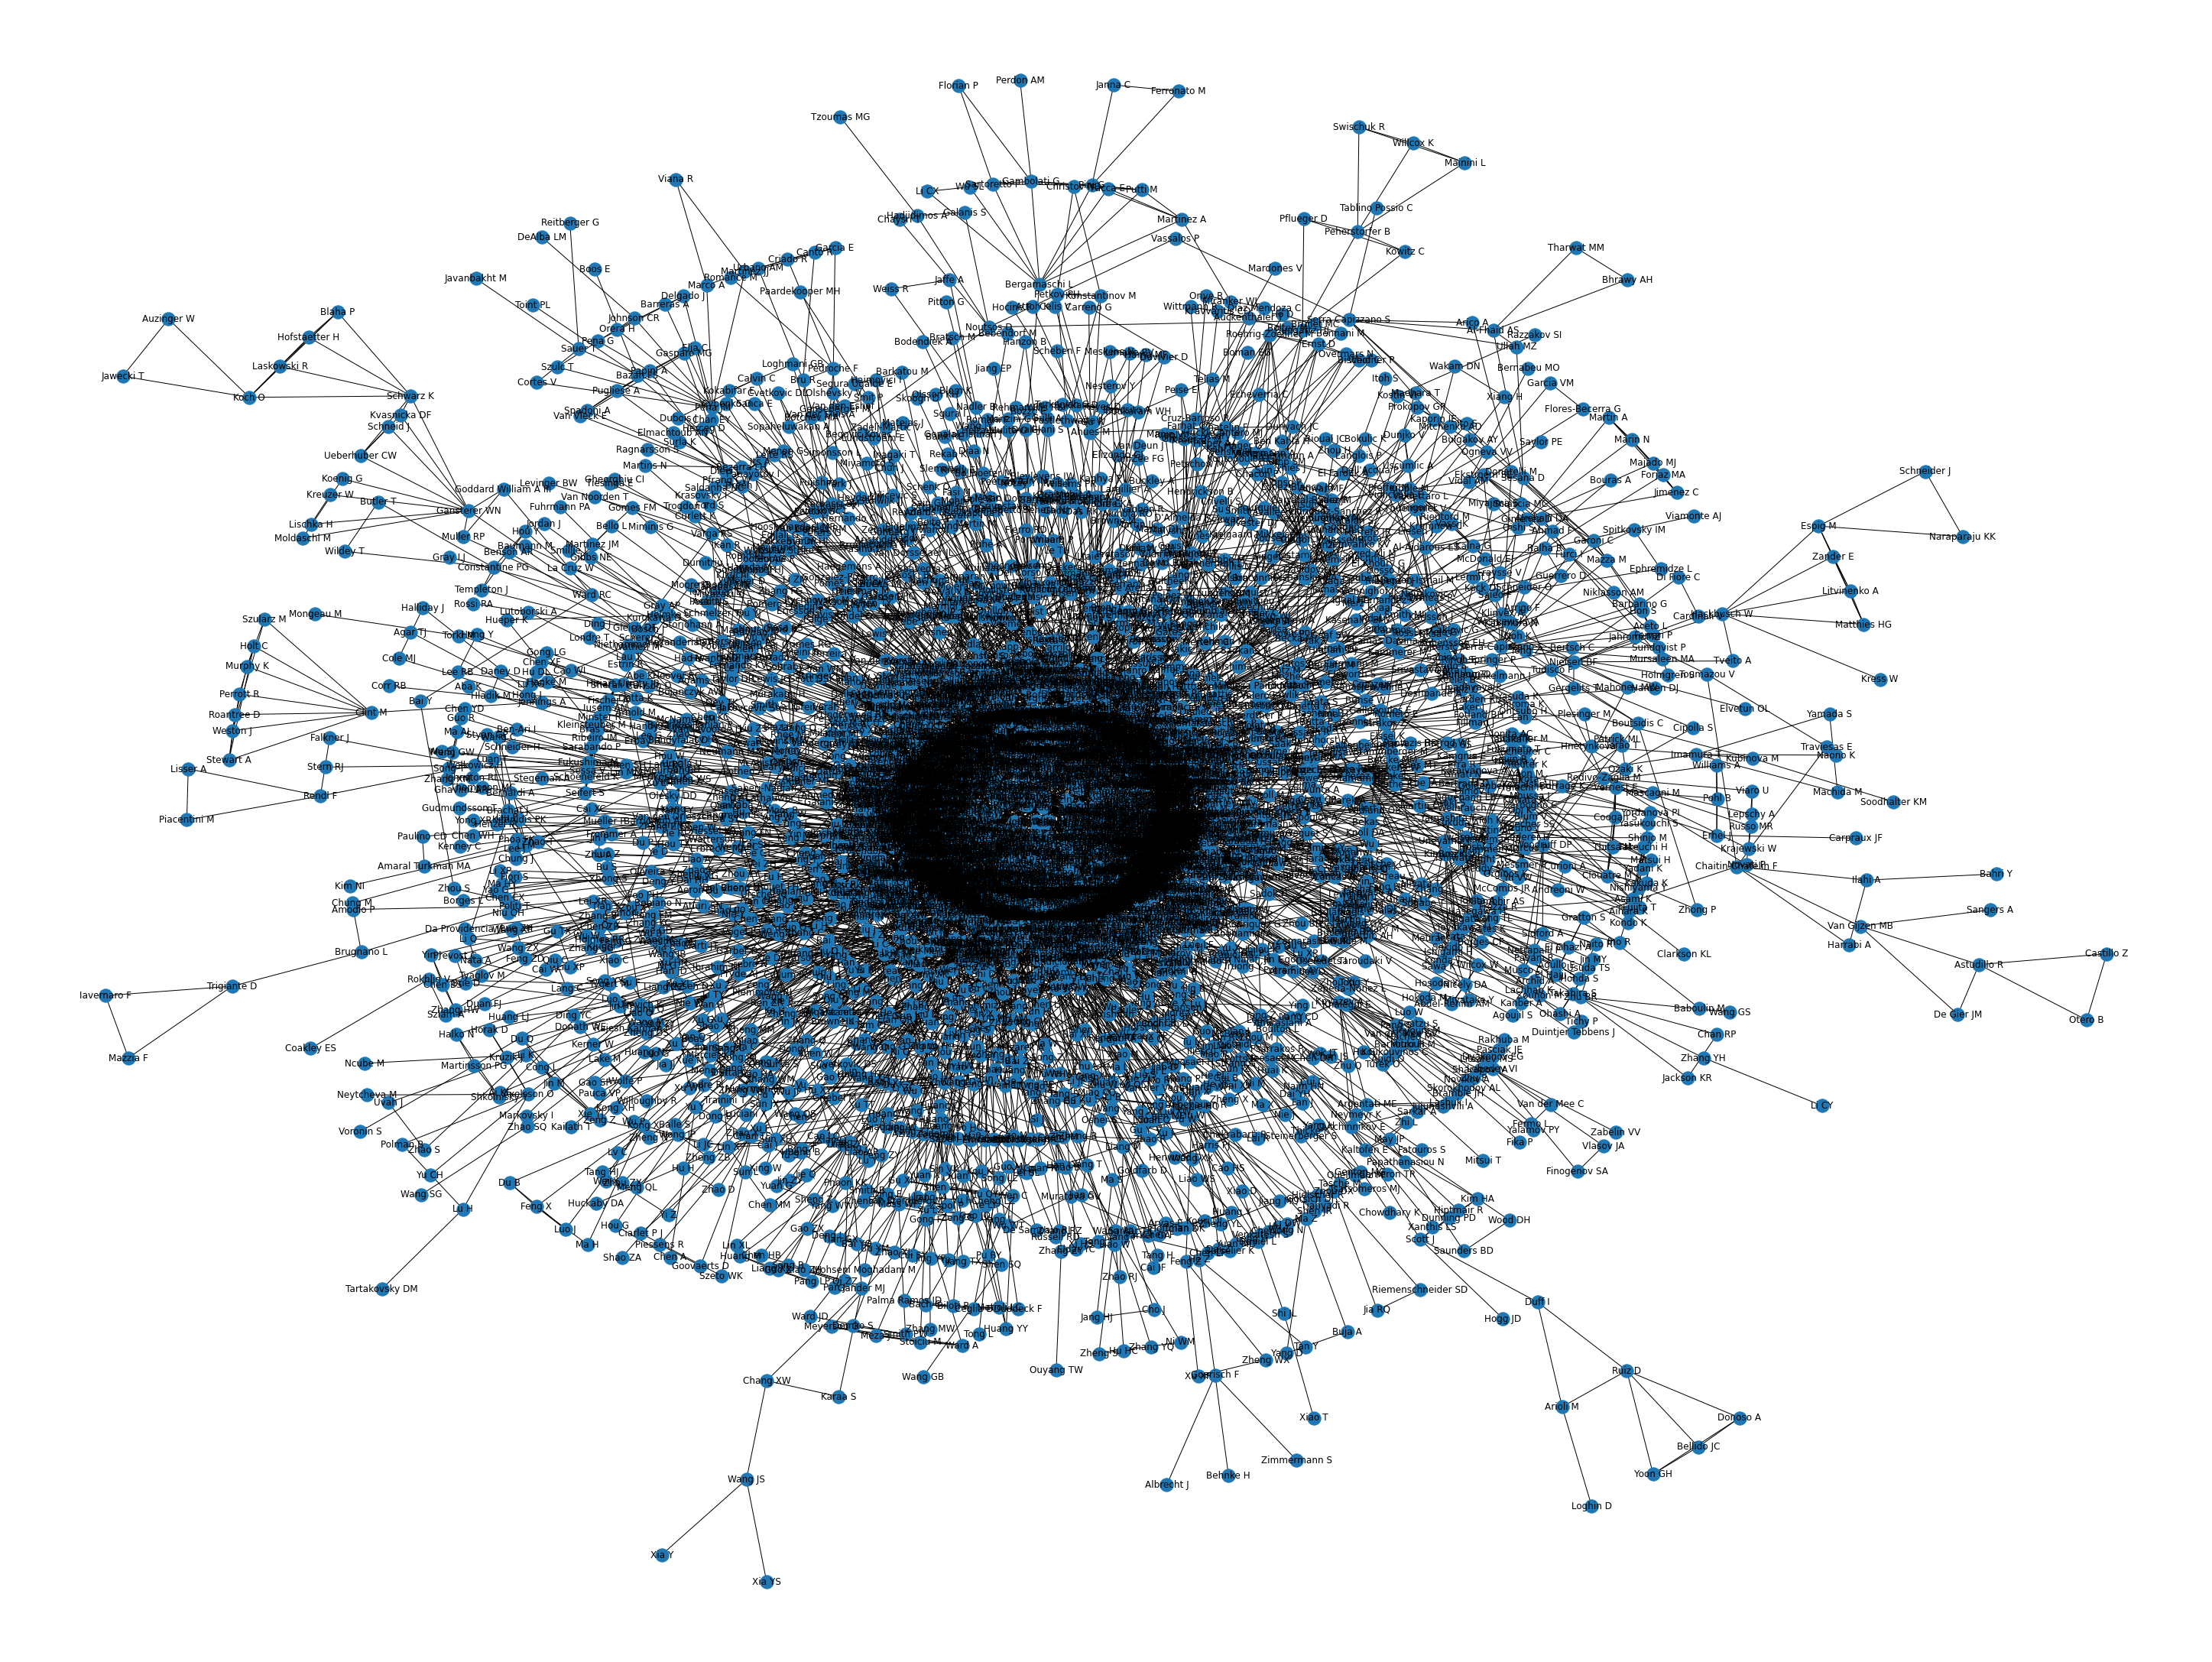

In [105]:
plt.figure(figsize = (40, 30))
G = nx.from_pandas_edgelist(df, source = 'author_0', target = 'author_1', edge_attr='count')
nx.draw_kamada_kawai(G, with_labels=True)



# Task 1b

b) The publication data that we are working with is not a static data set, but one that has evolved over time (and will continue evolving in the future as new papers get published). It therefore makes a lot of sense to consider it as a temporal network instead: Instead of defining a single coauthorship graph GC on the data, we now define a sequence of graphs GC(t1; t2) where t1; t2 2 f1966; 1967; : : : ; 2021g,t1 ≤ t2, and GC(t1; t2) is built like GC but only with publications from time interval [t1; t2].Write a function that reads in the file eigenvalue publications.txt and generates GC(t1; t2) for given years t1 ≤ t2.

In [106]:
# Analysis down by year

data_1970_1980 = data[data["Date_published"].isin(["1970","1980"])]
data_1980_1990 = data[data["Date_published"].isin(["1980","1990"])]
data_1990_2000 = data[data["Date_published"].isin(["1990","2000"])]
data_2000_2010 = data[data["Date_published"].isin(["2000","2010"])]
data_2010_2020 = data[data["Date_published"].isin(["2000","2020"])]

In [107]:
years = [ data_1970_1980,data_1980_1990,data_1990_2000,data_2000_2010,data_2010_2020]
for yr in years:
    print(yr.shape)

(67, 8)
(151, 8)
(237, 8)
(301, 8)
(367, 8)


In [108]:
# create pairs


#------------------
data_1970_1980['author_id_mapping'] = data_1970_1980.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_1970_1980 = (data_1970_1980.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_1970_1980 = paired_1970_1980.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_1970_1980[col] = df_1970_1980['Authors'].apply(lambda location: location[n])
#-------------------
#------------------
data_1980_1990['author_id_mapping'] = data_1980_1990.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_1980_1990 = (data_1980_1990.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_1980_1990 = paired_1980_1990.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_1980_1990[col] = df_1980_1990['Authors'].apply(lambda location: location[n])
#----------------------------
#------------------
data_1990_2000['author_id_mapping'] = data_1990_2000.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_1990_2000 = (data_1990_2000.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_1990_2000 = paired_1990_2000.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_1990_2000[col] = df_1990_2000['Authors'].apply(lambda location: location[n])
#-----------------------
#------------------
data_2000_2010['author_id_mapping'] = data_2000_2010.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2000_2010 = (data_2000_2010.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2000_2010 = paired_2000_2010.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2000_2010[col] = df_2000_2010['Authors'].apply(lambda location: location[n])
#------------------------
#------------------
data_2010_2020['author_id_mapping'] = data_2010_2020.apply(lambda z: cmp(z['author_list'], z['author_id_list']), axis=1)
paired_2010_2020 = (data_2010_2020.set_index('Title')['Authors']
   .str.split(',')
   .map(partial(combinations, r=2))
   .map(list)
   .explode()
   .reset_index())

df_2010_2020 = paired_2010_2020.groupby('Authors').size().to_frame(name = 'count').reset_index()
new_col_list = ['author_0','author_1']
for n,col in enumerate(new_col_list):
    df_2010_2020[col] = df_2010_2020['Authors'].apply(lambda location: location[n])

In [109]:

df_1970_1980 = df_1970_1980[df_1970_1980['author_0'] != df_1970_1980['author_1']]
df_1980_1990 = df_1980_1990[df_1980_1990['author_0'] != df_1980_1990['author_1']]
df_1990_2000 = df_1990_2000[df_1990_2000['author_0'] != df_1990_2000['author_1']]
df_2000_2010 = df_2000_2010[df_2000_2010['author_0'] != df_2000_2010['author_1']]
df_2010_2020 = df_2010_2020[df_2010_2020['author_0'] != df_2010_2020['author_1']]

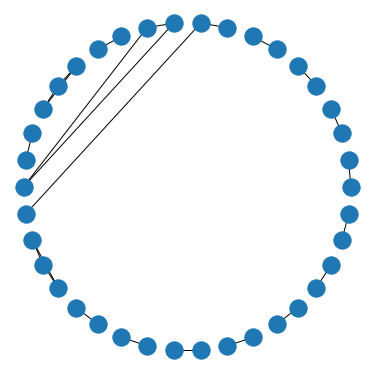

In [110]:
G_1970_1980 = nx.from_pandas_edgelist(df_1970_1980, 'author_0', 'author_1')

plt.figure(figsize = (5, 5))
nx.draw_circular(G_1970_1980, with_labels=False)

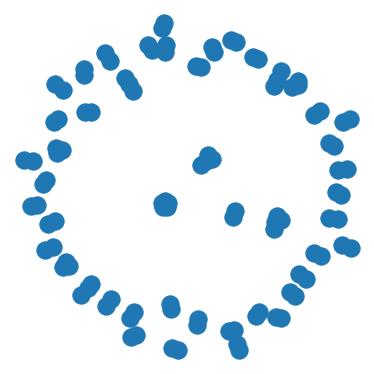

In [111]:
G_1980_1990 = nx.from_pandas_edgelist(df_1980_1990, 'author_0', 'author_1')

plt.figure(figsize = (5, 5))
nx.draw_spring(G_1980_1990, with_labels=False)

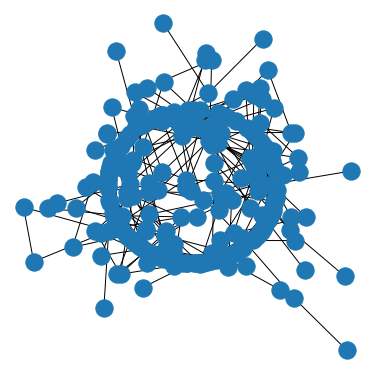

In [112]:
G_1990_2000 = nx.from_pandas_edgelist(df_1990_2000, 'author_0', 'author_1')

plt.figure(figsize = (5, 5))
nx.draw_kamada_kawai(G_1990_2000, with_labels=False)

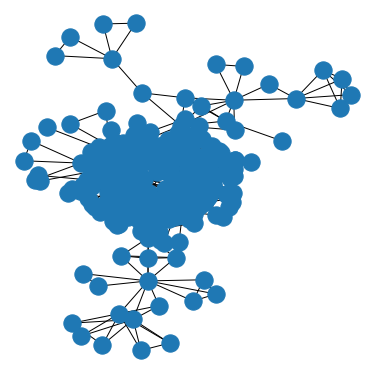

In [113]:
G_2000_2010 = nx.from_pandas_edgelist(df_2000_2010, 'author_0', 'author_1')

plt.figure(figsize = (5, 5))
nx.draw_kamada_kawai(G_2000_2010, with_labels=False)

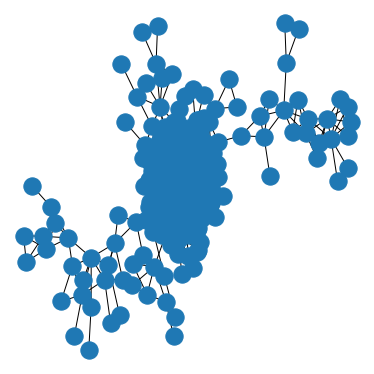

In [114]:
G_2010_2020 = nx.from_pandas_edgelist(df_2010_2020, 'author_0', 'author_1')

plt.figure(figsize = (5, 5))
nx.draw_kamada_kawai(G_2010_2020, with_labels=False)

# Task 2 Dig into the data

# Try to find out how the different sub-communities of authors evolved over time by applying spectral clustering techniques to the temporal networks G C (t 1 , t 2 ) for suit- ably chosen t1; t2 . Try out different choices of parameters and numbers of clusters. What can you observe?

In [115]:
print(len(df_1970_1980))

24


In [116]:
df_1970_1980

Authors  count        author_0       author_1
0         (Bathe KJ, Ramaswamy S)      1        Bathe KJ    Ramaswamy S
1               (Chang LJ, Ni WC)      1        Chang LJ          Ni WC
2       (Cullum JK, Willoughby R)      2       Cullum JK   Willoughby R
3   (Emami-Naeini A, Franklin GF)      1  Emami-Naeini A    Franklin GF
4            (Ericsson T, Ruhe A)      1      Ericsson T         Ruhe A
5     (Fescenko SF, Gavrilova ES)      1     Fescenko SF   Gavrilova ES
6        (Gerck E, D'Oliveira AB)      1         Gerck E  D'Oliveira AB
7         (Godunov SK, Ogneva VV)      1      Godunov SK      Ogneva VV
8       (Godunov SK, Prokopov GP)      1      Godunov SK    Prokopov GP
9          (Huang CP, Gregory RT)      1        Huang CP     Gregory RT
10      (Iljuhin AG, Fescenko SF)      1      Iljuhin AG    Fescenko SF
11     (Iljuhin AG, Gavrilova ES)      1      Iljuhin AG   Gavrilova ES
12          (Kagstroem B, Ruhe A)      1     Kagstroem B         Ruhe A
13         (Kalaba R, Spingarn K)      1        Kalaba R     Spingarn K
14       (Kalaba R, Tesfatsion L)      1        Kalaba R   Tesfatsion L
15      (Konkova TY, Savinova LT)      1      Konkova TY    Savinova LT
16     (Longsine DE, McCormick S)      1     Longsine DE    McCormick S
17           (Meyer D, Veselic K)      1         Meyer D      Veselic K
18       (Ogneva VV, Prokopov GP)      1       Ogneva VV    Prokopov GP
19         (Risken H, Vollmer HD)      1        Risken H     Vollmer HD
20      (Schajer GS, Mote C. D J)      1      Schajer GS    Mote C. D J
21     (Spingarn K, Tesfatsion L)      1      Spingarn K   Tesfatsion L
22        (Symm HJ, Wilkinson JH)      1         Symm HJ   Wilkinson JH
23        (Wolkowicz H, Styan GP)      1     Wolkowicz H       Styan GP

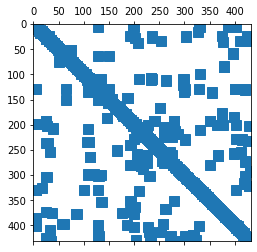

In [117]:
L = nx.laplacian_matrix(G_2000_2010)
L
L = L.astype('float')
L.todense()
%matplotlib inline
plt.spy(L)

In [118]:
lam, v = eigs(L, k=3, sigma=0.6)
lam

array([0.63135063+0.j, 0.55817444+0.j, 0.64393453+0.j])

In [119]:
v

array([[ 2.61373308e-18+0.j,  8.29512950e-18+0.j,  3.37282687e-19+0.j],
       [ 1.21144431e-19+0.j,  1.10876414e-18+0.j, -7.44105028e-19+0.j],
       [-1.04895246e-18+0.j, -1.77829639e-18+0.j, -1.26456520e-18+0.j],
       ...,
       [ 3.67549692e-18+0.j,  7.04264374e-18+0.j, -5.28974765e-18+0.j],
       [ 3.79865507e-18+0.j,  7.54949900e-18+0.j, -1.28379441e-17+0.j],
       [ 3.99127209e-18+0.j, -2.31819376e-01+0.j,  4.54051187e-17+0.j]])

In [120]:
vec=[(v[i][1].real,v[i][2].real) for i in range(len(v))]
vec

[(8.295129503202017e-18, 3.372826868346327e-19),
 (1.1087641395106786e-18, -7.441050275543934e-19),
 (-1.7782963934712182e-18, -1.2645651952628178e-18),
 (-3.3136960988632476e-18, -1.0636670534253407e-18),
 (1.8072839167552207e-17, 3.524279168565438e-17),
 (-2.544528265409361e-18, 1.0718226969232766e-17),
 (-8.472905616824965e-18, -5.482167438034519e-19),
 (1.353042362837199e-17, -1.5017840855536655e-18),
 (2.4569804832671637e-20, 4.381235508153081e-18),
 (-1.52235660969487e-17, 9.181344334652757e-18),
 (2.2964253371876205e-18, 6.68402297427057e-18),
 (-3.878238806429451e-18, 1.624565977573521e-18),
 (5.433343322128547e-18, 1.4792016008962603e-18),
 (-6.744435639904924e-18, 8.632482019979291e-19),
 (-4.727054255960665e-18, 9.064454232750501e-19),
 (4.43899205339408e-18, 2.0514674319822267e-18),
 (-4.871479431428136e-18, -3.756198406989083e-19),
 (-5.6538541567504765e-18, 9.020757840032549e-19),
 (4.365084129882549e-18, -1.3117924566278919e-18),
 (-1.1784310263374834e-18, -2.29792794642

In [121]:
G_2000_2010.nodes

NodeView(('Abdel-Rehim AM', 'Morgan R', 'Nicely DA', 'Wilcox W', 'Absil PA', 'Van Dooren P', 'Adam M', 'Maroulas J', 'Adams JL', 'Hartley TT', 'Veillette RJ', 'Ahues M', 'Hama MF', 'Largillier A', 'Aishima K', 'Matsuo T', 'Murota K', 'Sugihara M', 'Andrew AL', 'Tan RC', 'Andrisani E', 'Di Lena G', 'Badia JM', 'Vidal AM', 'Bai Z', 'Ko K', 'Lee LQ', 'Simon H', 'Su Y', 'Wang LW', 'Wu K', 'Bao L', 'Lin Y', 'Wei Y', 'Wu Q', 'Barlow JL', 'Slapnicar I', 'Becka M', 'Grigori L', 'Oksa G', 'Vajtersic M', 'Bellalij M', 'Saad Y', 'Sadok H', 'Bello L', 'La Cruz W', 'Raydan M', 'Benaini A', 'Laiymani D', 'Benner P', 'Effenberger C', 'Fassbender H', 'Bentbib AH', 'Kanber A', 'Bergamaschi L', 'Pini G', 'Sartoretto F', 'Bertagnolio F', 'Barkley D', 'Daube O', 'Le Quere P', 'Bini DA', 'Boito P', 'Eidelman Y', 'Gemignani L', 'Gohberg I', 'Blaha P', 'Hofstaetter H', 'Koch O', 'Laskowski R', 'Schwarz K', 'Blouza A', 'Coquel F', 'Hamel F', 'Bohnhorst B', 'Bunse-Gerstner A', 'Bondyfalat D', 'Mourrain B', 'Pa

In [122]:
pos = {node:vec[index] for index, node in enumerate(G_2000_2010.nodes)}

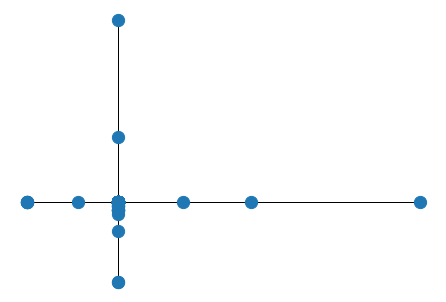

In [123]:
nx.draw(G_2000_2010, pos, node_size=150)

In [52]:
#finding the subgraphs for authors in G_2000_2010

In [124]:
#function to return first n items of dict as a list
def take(n, iterable):
    return list(islice(iterable, n))

In [125]:
def find_cliques_size_k(G, k):
    all_cliques = set()
    for clique in nx.find_cliques(G):
        if len(clique) == k:
            all_cliques.add(tuple(sorted(clique)))
        elif len(clique) > k:
            for mini_clique in combinations(clique, k):
                all_cliques.add(tuple(sorted(mini_clique)))
    return len(all_cliques)

for k in [3, 4, 5]:
    print(find_cliques_size_k(G_2000_2010, k))

215
71
17


In [126]:
nx.enumerate_all_cliques(G_2000_2010)

<generator object enumerate_all_cliques at 0x7f87c8954360>

In [127]:
# find clique counts per actor
cliques_count = nx.number_of_cliques(G_2000_2010)

cl_sorted_tuples = sorted(cliques_count.items(), key=lambda item: item[1], reverse=True)
cl_sorted_dict = {k: v for k, v in cl_sorted_tuples}

# show top 
take(30, cl_sorted_dict.items())

[('Van Dooren P', 7),
 ('Van Barel M', 5),
 ('Bai Z', 4),
 ('Lin WW', 4),
 ('Sakurai T', 4),
 ('Tadano H', 4),
 ('Golub G', 4),
 ('Wei Y', 3),
 ('Chan RH', 3),
 ('Jia Z', 3),
 ('Van der Vorst H', 3),
 ('Hu XY', 3),
 ('Zhang L', 3),
 ('Vandebril R', 3),
 ('Murota K', 2),
 ('Simon H', 2),
 ('Slapnicar I', 2),
 ('Grigori L', 2),
 ('Benner P', 2),
 ('Fassbender H', 2),
 ('Gemignani L', 2),
 ('Chaitin-Chatelin F', 2),
 ('Wang W', 2),
 ('Wang CS', 2),
 ('Dai H', 2),
 ('Dopico F', 2),
 ('Drmac Z', 2),
 ('Elden L', 2),
 ("O'Leary DP", 2),
 ('Mehrdoust F', 2)]

In [128]:
nx.cliques_containing_node(G_2000_2010, nodes= 'Van Dooren P')

[['Mastronardi N', 'Van Dooren P', 'Van Barel M', 'Vandebril R'],
 ['Mastronardi N', 'Van Dooren P', 'Tyrtyshnikov EE'],
 ['Vanberghen Y', 'Van Barel M', 'Van Dooren P'],
 ['Frederix K', 'Van Barel M', 'Van Dooren P', 'Vandebril R'],
 ['Absil PA', 'Van Dooren P'],
 ['Van Dooren P', 'Stewart M'],
 ['Van Dooren P', 'Solna K', 'Golub G']]

In [129]:
nx.cliques_containing_node(G_2000_2010, nodes= 'Van Barel M')

[['Mastronardi N', 'Van Dooren P', 'Van Barel M', 'Vandebril R'],
 ['Vanberghen Y', 'Van Barel M', 'Van Dooren P'],
 ['Frederix K', 'Van Barel M', 'Van Dooren P', 'Vandebril R'],
 ['Chesnokov A', 'Van Barel M', 'Deckers K'],
 ['Van Barel M', 'Gemignani L', 'Delvaux S']]

In [130]:
from networkx.algorithms.community import k_clique_communities

list(k_clique_communities(G_2000_2010, 5))

[frozenset({'Blaha P', 'Hofstaetter H', 'Koch O', 'Laskowski R', 'Schwarz K'}),
 frozenset({'Chang WJ',
            'Huang TM',
            'Huang YL',
            'Lin WW',
            'Wang W',
            'Wang WC'}),
 frozenset({'Bao L', 'Lin Y', 'Wei Y', 'Wu Q', 'Zhou L'}),
 frozenset({'Hashiguchi H',
            'Hiraoka K',
            'Kakinuma Y',
            'Kudo K',
            'Kuwajima Y',
            'Shigehara T'}),
 frozenset({'Barkley D',
            'Bertagnolio F',
            'Daube O',
            'Le Quere P',
            'Tuckerman LS'}),
 frozenset({'Bini DA', 'Boito P', 'Eidelman Y', 'Gemignani L', 'Gohberg I'}),
 frozenset({'Bai Z', 'Simon H', 'Wang LW', 'Wu K', 'Yamazaki I'})]

In [131]:
Dooren_Barel_cliques=G_2000_2010.subgraph(['Mastronardi N', 'Van Dooren P', 'Vandebril R', 'Van Barel M','Frederix K', 'Vandebril R', 'Van Dooren P', 'Van Barel M','Van Dooren P', 'Vanberghen Y', 'Van Barel M'])

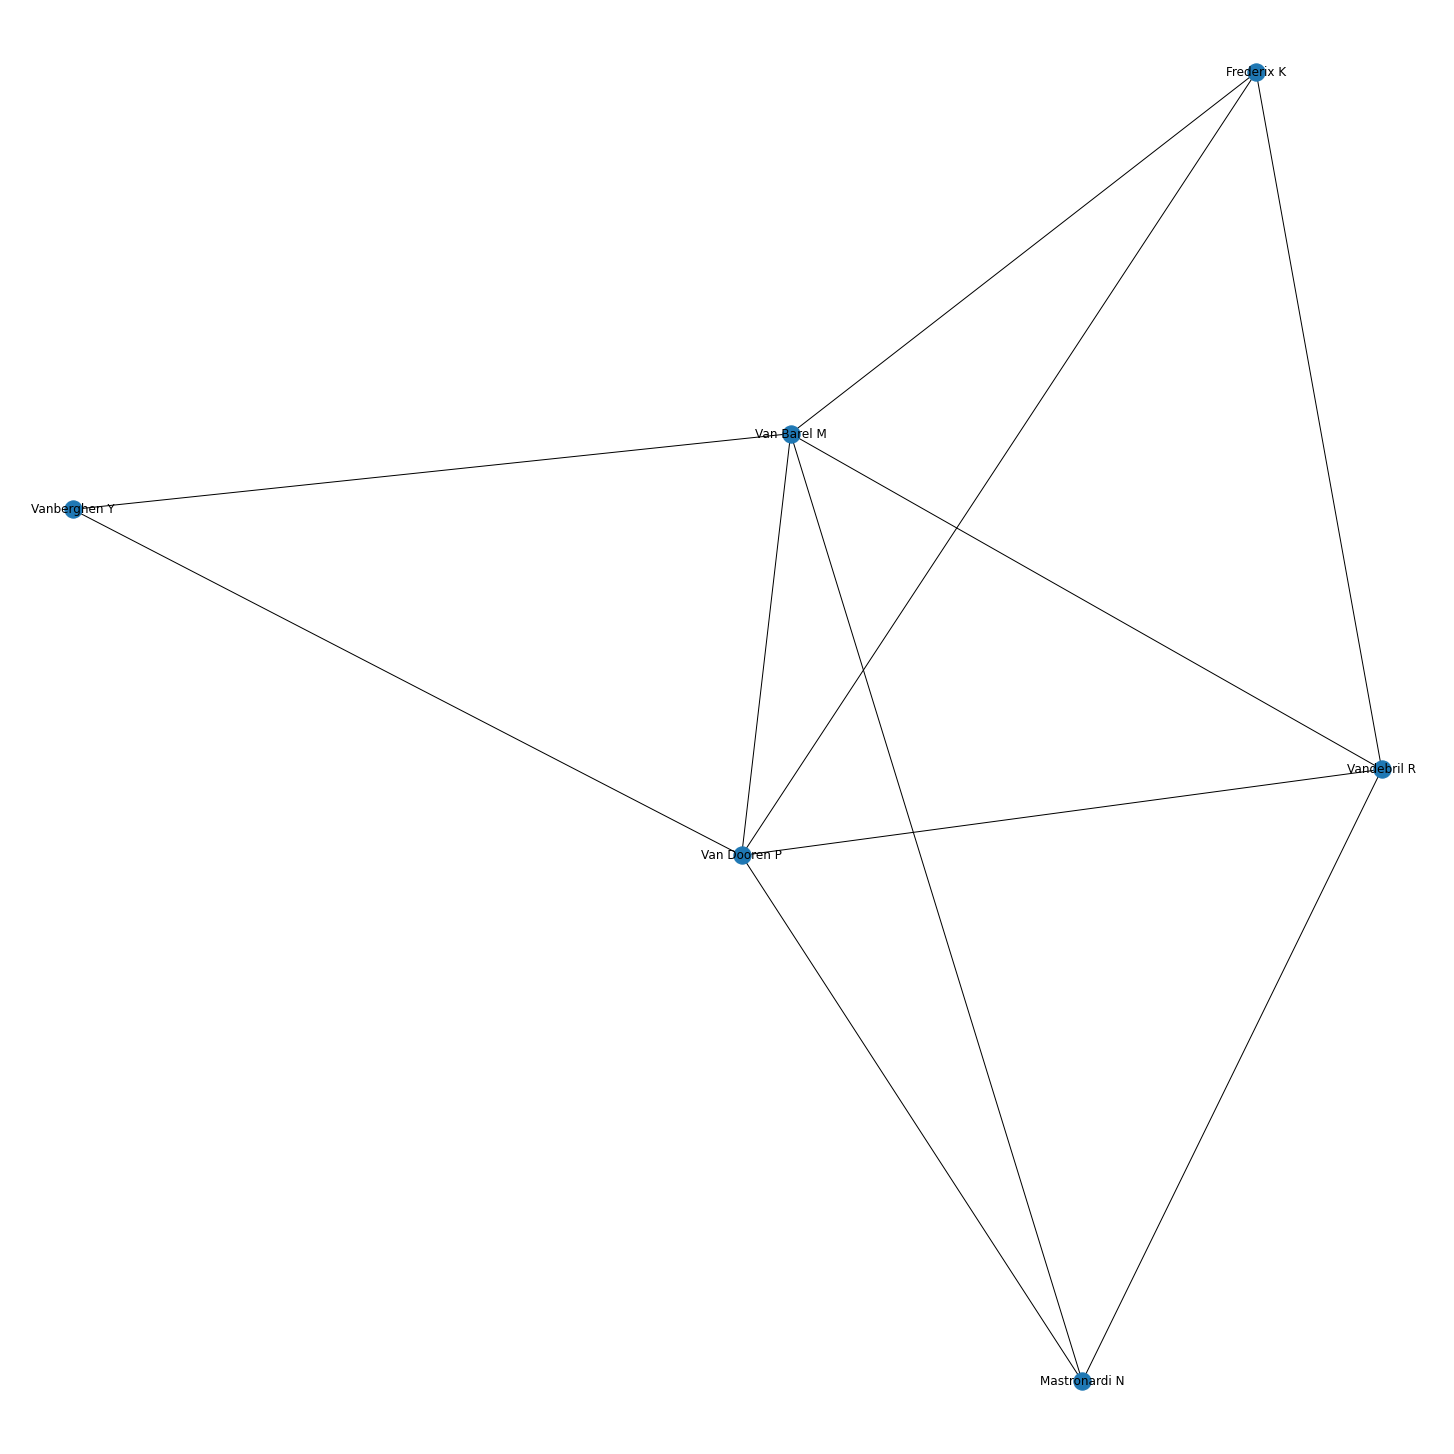

In [132]:
plt.figure(figsize = (20, 20))
nx.draw(Dooren_Barel_cliques, with_labels=True)

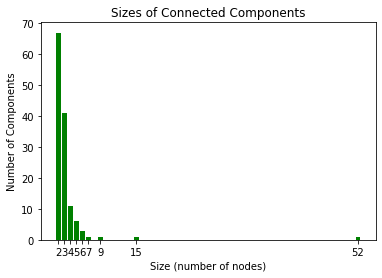

In [133]:
from collections import Counter
size_sequence = sorted([len(c) for c in sorted(nx.connected_components(G_2000_2010), key=len, reverse=True)])
sizeCount = Counter(size_sequence)
deg, cnt = zip(*sizeCount.items())

plt.bar(deg, cnt, color='g')
plt.title("Sizes of Connected Components")
plt.ylabel("Number of Components")
plt.xticks(deg)
plt.xlabel("Size (number of nodes)")
plt.show()

In [134]:
largest_cc = max(nx.connected_components(G_2000_2010), key=len)

In [135]:
largest_cc

{'Absil PA',
 'Bai Z',
 'Bini DA',
 'Boito P',
 'Chan RH',
 'Chesnokov A',
 'Deckers K',
 'Del Corso GM',
 'Delvaux S',
 'Eidelman Y',
 'Frederix K',
 'Futamura Y',
 'Gemignani L',
 'Gohberg I',
 'Golub G',
 'Hochstenbach ME',
 'Huang X',
 'Ikegami T',
 'Ko K',
 'Kuramashi Y',
 'Lee LQ',
 'Liao BS',
 'Mastronardi N',
 'Nagashima U',
 'Ng M',
 'Ohno H',
 'Potts D',
 'Quillen P',
 'Sakurai T',
 'Senzaki K',
 'Simon H',
 'Sleijpen GL',
 'Solna K',
 'Steidl G',
 'Stewart M',
 'Su Y',
 'Tadano H',
 'Tyrtyshnikov EE',
 'Van Barel M',
 'Van Dooren P',
 'Van Dorsselaer JL',
 'Van der Vorst H',
 'Vanberghen Y',
 'Vandebril R',
 'Wang LW',
 'Wu K',
 'Yamazaki I',
 'Ye Q',
 'Yip AM',
 'Zha H',
 'Zhang Z',
 'Zhang ZN'}

In [136]:
cluster_coeffs = nx.clustering(G_2000_2010, nodes=None, weight='count')

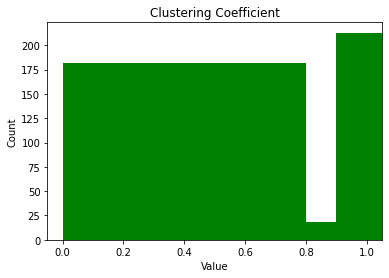

In [137]:
plt.hist(cluster_coeffs.values(), width=0.80, color='g')
plt.title("Clustering Coefficient")
plt.ylabel("Count")
plt.xlabel("Value")
plt.show()

# 2 b) Try to find the most \important" authors in the numerical eigenvalue computation community (and how their importance changed over time) by computing centrality measures on the nodes of GC(t1; t2). The considerations in part a) of course also apply here.

In [138]:
#function to return first n items of dict as a list
from itertools import islice
def take(n, iterable):
    return list(islice(iterable, n))


In [139]:
# degree centrality
dc_sorted_tuples = sorted(nx.degree_centrality(G_2000_2010).items(), key=lambda item: item[1], reverse=True)
dc_sorted_dict = {k: v for k, v in dc_sorted_tuples}

# show top 5
take(5, dc_sorted_dict.items())

[('Bai Z', 0.027842227378190254),
 ('Van Dooren P', 0.02320185614849188),
 ('Lin WW', 0.02320185614849188),
 ('Van Barel M', 0.02088167053364269),
 ('Sakurai T', 0.018561484918793503)]

In [140]:
# show top 40
take(40, dc_sorted_dict.items())

[('Bai Z', 0.027842227378190254),
 ('Van Dooren P', 0.02320185614849188),
 ('Lin WW', 0.02320185614849188),
 ('Van Barel M', 0.02088167053364269),
 ('Sakurai T', 0.018561484918793503),
 ('Tadano H', 0.018561484918793503),
 ('Wei Y', 0.016241299303944315),
 ('Gemignani L', 0.013921113689095127),
 ('Wang W', 0.013921113689095127),
 ('Golub G', 0.013921113689095127),
 ('Kuwajima Y', 0.013921113689095127),
 ('Shigehara T', 0.013921113689095127),
 ('Huang TM', 0.013921113689095127),
 ('Simon H', 0.01160092807424594),
 ('Grigori L', 0.01160092807424594),
 ('Chan RH', 0.01160092807424594),
 ('Chang WJ', 0.01160092807424594),
 ('Huang YL', 0.01160092807424594),
 ('Wang WC', 0.01160092807424594),
 ('Hashiguchi H', 0.01160092807424594),
 ('Hiraoka K', 0.01160092807424594),
 ('Kakinuma Y', 0.01160092807424594),
 ('Kudo K', 0.01160092807424594),
 ('Vandebril R', 0.01160092807424594),
 ('Murota K', 0.009280742459396751),
 ('Wang LW', 0.009280742459396751),
 ('Wu K', 0.009280742459396751),
 ('Bao L'

In [141]:
# closeness centrality
cc_sorted_tuples = sorted(nx.closeness_centrality(G_2000_2010).items(), key=lambda item: item[1], reverse=True)
cc_sorted_dict = {k: v for k, v in cc_sorted_tuples}

# show top 5
take(5, cc_sorted_dict.items())

[('Golub G', 0.03944315545243619),
 ('Van Dooren P', 0.03819495433052365),
 ('Zha H', 0.03657456232862265),
 ('Solna K', 0.033526682134570766),
 ('Simon H', 0.03334145184653446)]

In [142]:
# show top 40
take(40, cc_sorted_dict.items())

[('Golub G', 0.03944315545243619),
 ('Van Dooren P', 0.03819495433052365),
 ('Zha H', 0.03657456232862265),
 ('Solna K', 0.033526682134570766),
 ('Simon H', 0.03334145184653446),
 ('Zhang Z', 0.033158257056168886),
 ('Van Barel M', 0.03227167264290234),
 ('Mastronardi N', 0.031595826095407),
 ('Vandebril R', 0.030947706585757632),
 ('Van der Vorst H', 0.03063351667118141),
 ('Tyrtyshnikov EE', 0.03063351667118141),
 ('Frederix K', 0.03063351667118141),
 ('Vanberghen Y', 0.03032564213177255),
 ('Ye Q', 0.030023894448869343),
 ('Bai Z', 0.029875261308033356),
 ('Absil PA', 0.029013474924147777),
 ('Stewart M', 0.029013474924147777),
 ('Wang LW', 0.028068850159175526),
 ('Wu K', 0.028068850159175526),
 ('Yamazaki I', 0.028068850159175526),
 ('Gemignani L', 0.026468433264134814),
 ('Delvaux S', 0.026012080966477318),
 ('Zhang ZN', 0.026012080966477318),
 ('Chesnokov A', 0.02557119823823194),
 ('Deckers K', 0.02557119823823194),
 ('Lin WW', 0.02526424336169116),
 ('Chan RH', 0.0252502208544

In [143]:
# betweenness centrality
bc_sorted_tuples = sorted(nx.betweenness_centrality(G_2000_2010).items(), key=lambda item: item[1], reverse=True)
bc_sorted_dict = {k: v for k, v in bc_sorted_tuples}

# show top 5
take(5, bc_sorted_dict.items())

[('Golub G', 0.008439000701451465),
 ('Van Dooren P', 0.007838270472490512),
 ('Zha H', 0.006410187233583338),
 ('Simon H', 0.006237522257594561),
 ('Bai Z', 0.005827442939621216)]

In [144]:
# show top 40
take(40, bc_sorted_dict.items())

[('Golub G', 0.008439000701451465),
 ('Van Dooren P', 0.007838270472490512),
 ('Zha H', 0.006410187233583338),
 ('Simon H', 0.006237522257594561),
 ('Bai Z', 0.005827442939621216),
 ('Van Barel M', 0.003866976024748647),
 ('Tyrtyshnikov EE', 0.0024820590298386663),
 ('Chan RH', 0.0020719797118653213),
 ('Gemignani L', 0.002028813467868127),
 ('Van der Vorst H', 0.001575567905897588),
 ('Sakurai T', 0.001257216856418281),
 ('Tadano H', 0.001257216856418281),
 ('Lin WW', 0.0007014514649544057),
 ('Vandebril R', 0.0005431752369646937),
 ('Ye Q', 0.0005395780499649275),
 ('Zhang Z', 0.0005395780499649275),
 ('Mastronardi N', 0.0003561215129768521),
 ('Wang CS', 0.00025899746398316516),
 ('Wei Y', 0.00020503965898667243),
 ('Li RC', 0.00014029029299088112),
 ('Wu G', 7.554092699508985e-05),
 ('Grigori L', 6.474936599579129e-05),
 ('Wang W', 6.474936599579129e-05),
 ('Kressner D', 6.474936599579129e-05),
 ('Huang TM', 6.474936599579129e-05),
 ('Fassbender H', 4.3166243997194194e-05),
 ('Chai

# Trial with temporal Graphs

Visualizing Diffusion Grid for 2000 2010

In [145]:

L = nx.laplacian_matrix(G_2000_2010)
L = L.astype('float')
pos = nx.kamada_kawai_layout(G_2000_2010)
n = len(G_2000_2010.nodes)

In [146]:
u0 = np.random.rand(n,1)

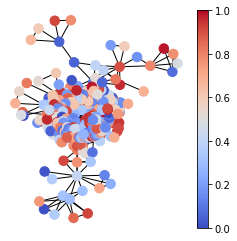

In [88]:
fig = plt.figure(figsize=(4,4))
cmap = 'coolwarm'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
plt.colorbar(sm);
nx.draw(G_2000_2010, pos, node_size=90, node_color=u0, cmap=cmap, vmin=0, vmax=1)